In [1]:
# setup... requires numpy and matplot lib
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# plot setup
_plt_x = 12.
_plt_y = _plt_x * 0.8

def normal_pdf(mu, sigma):
    '''
    PDF of a normal distribution.
    '''
    def pdf(x):
        return 1./(sigma * np.sqrt(2 * np.pi)) *\
                   np.exp(-(x - mu)**2 / (2*(sigma)**2))
    return pdf


# MCMC

Credits: most of this presentation is based off Bishop's Pattern Recognition and Machine Learning

See also: [Iain Murray at MLSS 09](http://videolectures.net/mlss09uk_murray_mcmc/) and [Iain Murray at NIPS 2015](http://research.microsoft.com/apps/video/default.aspx?id=259575)

# Outline

* Motivation - what we're trying to solve
* What's wrong with the methods we saw last week?
* Simple MCMC example
* Why does this work?
* Full Metropolis - Hastings Algorithm
* Gibbs Sampling
* Slice Sampling
* Hamiltonian Monte Carlo

# Motivation - what we're trying to solve...

Recall the problem we're trying to solve:
 * In Bayesian inference, we can typically write down a prior, $\mathbb{P}(\mathbf{z})$ and a likelihood functions $\mathbb{P}(\mathcal{D} | \mathbf{z})$.
 * We're then interested in working with the posterior, $$p(\mathbf{z} | \mathcal{D}) = \frac{1}{Z} \mathbb{P}(\mathcal{D} | \mathbf{z} )\mathbb{P}(\mathbf{z} ) = \frac{1}{Z}\tilde{p}(\mathbf{z}),$$ where $Z$ is a normalising constant.
 * If we're being Bayesian, we'd then write down a loss function $\mathcal{L}$ which we can then optimise with respect to the posterior expected loss.
 * More generally, we'd just like to be able to be able to evaluate functions of the form $E[f(\cdot)] = \int f(\mathbf{z}) p(\mathbf{z})\text{ d}\mathbf{z}$ for some $f(\cdot)$
 * Why? $f(\cdot)$ could be:
      - Your loss function $\mathcal{L}(\cdot)$.
      - $f(\mathbf{z}) = 1$ to get the normalising constant $Z$ (if $p$ is unnormalised, $\tilde{p}(\mathbf{z})$)
      - $f(\mathbf{z}_i) = \mathbf{z}_i$ to get marginals (by integrating over $\mathbf{z}_{\setminus i}$).
      - $f(z) = \mathbb{1}(z \in \mathcal{S}) \Rightarrow E[f(z)] = \mathbb{P}(z \in \mathcal{S})$
      - etc...
 * Problem - we can't evaluate $$E[f(\cdot)] = \int  f(\mathbf{z}) p(\mathbf{z})\text{ d}\mathbf{z}$$
 * Solution... approximate it with $$E[f(\cdot)] \approx \frac{1}{N}\sum_{i=1}^N f(\mathbf{z}_i)$$ where $\mathbf{z}_i \sim p(\cdot)$
 

# How do we sample from $p(\cdot)$ if it's intractable?

Last we Ricky showed us two methods...
* Rejection sampling
* Importance sampling

Both relied on a proposal distribution $q(\cdot)$ that had to be "close" to $p(\cdot)$ in order to be effective...

## Why is this a problem?

Variant of the curse of diminsionality:
* in high dimensions, it is very difficult to choose $q(\cdot)$ close to $p(\cdot)$

Artificial illustrative example:
* We wish to sample from a multivariate zero-mean Gaussian with covariance $\sigma^2_p\mathbf{I}$ using rejection sampling.
* The proposal distribution, $q$, is also a zero-mean Gaussian with covariance $\sigma^2_q\mathbf{I}$.
*  We need $q$ to "cover" $p$, so $\sigma^2_q\mathbf{I} \geq \sigma^2_p\mathbf{I}$ to ensure that there exists $k$ such that $k q(z) \geq p(z)$.
* In $D$ dimensions, the optimal value for $k = (\frac{\sigma_q}{\sigma_p})^{D}$.

![Normal distribution](normaldist.jpg)

The acceptance rate is $\frac{1}{k}$ so if $\sigma_q$ is just $1\%$ larger than $\sigma_p$, for $D = 1000$ the acceptance rate will be just $\frac{1}{20000}$

# MCMC - basic version

**Like importance** and **rejection** sampling, we sample from a proposal distribution $q(\mathbf{z})$

***Unlike* importance** and **rejection** sampling, each sample depends on the current state: $q(\mathbf{z} | \mathbf{z}^{(t)})$... so the sequence of samples $\mathbf{z}^{(1)}, \mathbf{z}^{(2)}, \dots$ that you get from the algorithm form a Markov chain.

Let's start by seeing the algorithm at work for a special case, and then we'll show why it works more generally.

The basic *Metropolis* algorithm assumes that the proposal distribution is symmetric (we'll relax this later). i.e. $q(\mathbf{z}_A | \mathbf{z}_B) = q(\mathbf{z}_B | \mathbf{z}_A)$

#### *Metropolis* algorithm
We draw a sample $\mathbf{z}^\star \sim q(\mathbf{z} | \mathbf{z}^{(t)})$ and accept it with probability:
$$
A(\mathbf{z}^\star, \mathbf{z}^{(t)}) = \min\left(1 , \frac{\tilde{p}(\mathbf{z}^\star)}{\tilde{p}(\mathbf{z}^{(t)})}\right)
$$

If we accept the sample, we add $\mathbf{z}^\star$ to our list of samples. If not, we add another copy of $\mathbf{z}^{(t)}$ to our list of samples.

In [2]:
def metropolis(N, z_0, p, q):
    '''
    Very simple (inefficient) implementation of the
    metropolis algorithm.
    N - the number of samples.
    z_0 - some initialisation point
    p - unnormalised distribution of interest
    q - proposal distribution that samples conditional on the last point
    '''
    z = [z_0]
    for i in xrange(1, N):
        z_star = q(z[i-1])
        u = np.random.rand() # uniform random number in [0, 1]
        A = min(1., p(z_star) / p(z[i - 1]))
        if u < A:
            z.append(z_star)
        else:
            z.append(z[i - 1])
    return np.array(z)

# Simple example

Assume we know the (unnormalised) density function that generates the CPSC 540 grades.

We'd like to be able to calculate the mean and variance of this crazy distribution. Let's use the `metropolis` algorithm defined above.

We'll use the following proposal distribution: $q(z_t | z_{t-1}) \sim \mathcal{N}(z_{t-1}, 0.1)$

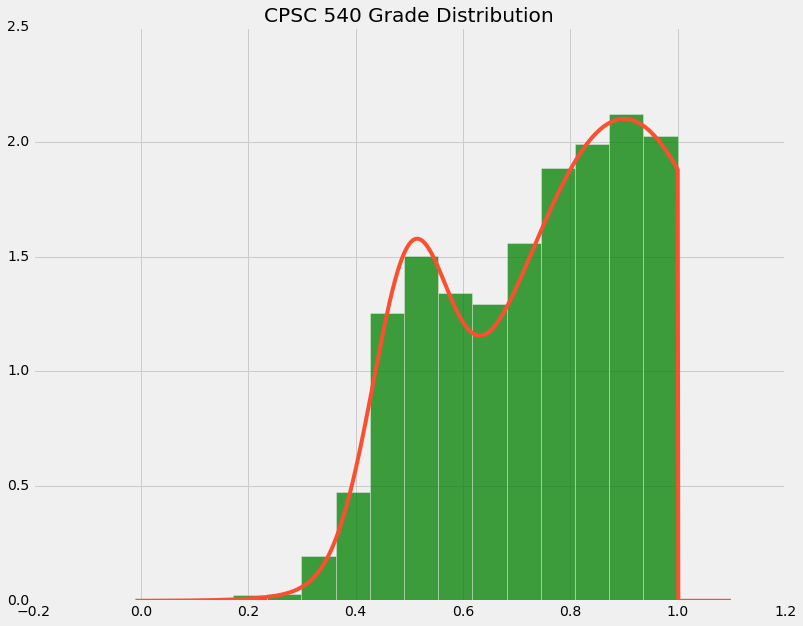

Average grade = 0.725835
Standard deviation = 0.178573
P(z < 0.5) = 0.139200
P(z > 0.9) = 0.206200


In [3]:
# plot setup
plt.figure(figsize=(_plt_x,_plt_y))

# Metropolis inputs
N = 5000
z_0 = 0.5

def p_tilde(x):
    I = np.array(x >= 0, dtype='float64') * np.array(x <= 1, dtype='float64') # indicator x \in [0, 1]
    z = I * 0.4*np.exp(-((x-0.5)/0.1)**2) + 0.7*np.exp(-((x-0.9)/0.3)**2)
    return I * z

q = lambda x: 0.2 * np.random.randn() + x

# Get the samples
z = metropolis(N, z_0, p_tilde, q)


# Plot the results
n, bins, patches = plt.hist(z, 15, normed=1, facecolor='green', alpha=0.75)

x = np.arange(-0.01, 1.1, 0.001)
plt.plot(x, p_tilde(x) * 3.) # the 3. just scales the density function so the two plots line up
plt.title("CPSC 540 Grade Distribution")
plt.show()

# Calculate E[f(x)] using the samples
print "Average grade = %f" % (z.mean())
print "Standard deviation = %f" % (z.std())
print "P(z < 0.5) = %f" % (np.array(z < 0.5, dtype='float64').sum() / float(N))
print "P(z > 0.9) = %f" % (np.array(z > 0.9, dtype='float64').sum() / float(N))

# How does the algorithm work?

In [4]:
z_i = np.arange(0., 1., 0.05)
i = 18

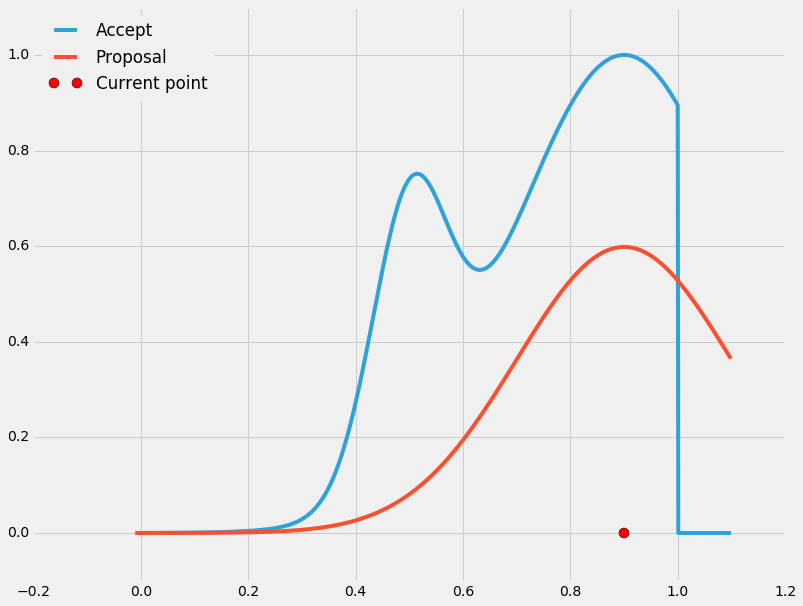

In [5]:
# plot setup
plt.figure(figsize=(_plt_x,_plt_y))
# Acceptance probability function
A = lambda x, z: np.minimum(1, p_tilde(x) / p_tilde(z))
# pdf of the proposal distribution
q_pdf = normal_pdf(mu = z_i[i], sigma=0.2)

# plotting functions
plt.plot(x, A(x, z_i[i]), label='Accept')
plt.plot(x, 0.3*q_pdf(x), label='Proposal')
plt.plot([z_i[i]], [0.], 'ro', ms=10., label='Current point')
plt.legend(loc=2)
plt.ylim(-0.1, 1.1)
plt.show()
i = (i + 1) % 20

# Why does this work?

## Markov Chain refresher
Informally: a sequence of random variables where the future is conditionally independent of the past given the present. i.e.

$P(X_{n+1}| X_{n}, X_{n-1}, ... , X_{1}, X_{0}) = P(X_{n+1}| X_{n})$ 

A simple example:

![Markov Chain](weather-model.png)

We specify a Markov chain by giving an initial distribution, $$p(\mathbf{z}_0),$$ and conditional probabilities of subsequent states, in the form of transition probabilities $$T(\mathbf{z}_{t} , \mathbf{z}_{t+1}) = p(\mathbf{z}_{t+1} | \mathbf{z}_t)$$

The marginal probability can be expressed inters of the marginal probability of the previous variable:
$$
p(\mathbf{z}_{t+1}) = \sum_{\mathbf{z^{(t)}}} p(\mathbf{z}_{t+1} | \mathbf{z}_t)p(\mathbf{z}_t)
$$

A distribution is stationary (or invariant) if applying the transition operator leaves the marginals unchanged:
$$
p^\star(\mathbf{z}) = \sum_{\mathbf{z}'} T(\mathbf{z}', \mathbf{z})p^\star(\mathbf{z}')
$$


In [31]:
T = np.array([[0.6, 0.3, 0.1],
              [0.2, 0.3, 0.5],
              [0.4, 0.1, 0.5]])
#x = np.array([1., 0., 0.])
x = np.array([0., 1., 0.])
#x = np.array([0., 0., 1.])

In [32]:
for i in range(10):
    x = np.dot(T.T, x)
    print i, x

0 [ 0.2  0.3  0.5]
1 [ 0.38  0.2   0.42]
2 [ 0.436  0.216  0.348]
3 [ 0.444   0.2304  0.3256]
4 [ 0.44272  0.23488  0.3224 ]
5 [ 0.441568  0.23552   0.322912]
6 [ 0.4412096  0.2354176  0.3233728]
7 [ 0.4411584   0.23532544  0.32351616]
8 [ 0.44116659  0.23529677  0.32353664]
9 [ 0.44117396  0.23529267  0.32353336]


# Detailed Balance

A **sufficient** but ***not*** **necessary** condition for ensuring the required distribution $p(\mathbf{z})$ is the stationary distribution is to choose the transition probabilities to satisfy ***detailed balance***:
$$ {p}(\mathbf{z}) T(\mathbf{z}, \mathbf{z}') =  {p}(\mathbf{z}') T(\mathbf{z}', \mathbf{z})$$

why?

$$
\sum_{\mathbf{z}'}{p}(\mathbf{z}) T(\mathbf{z}, \mathbf{z}') = \sum_{\mathbf{z}'} {p}(\mathbf{z}') T(\mathbf{z}', \mathbf{z})
$$

$$
{p}(\mathbf{z})\sum_{\mathbf{z}'} p(\mathbf{z}' | \mathbf{z}) = \sum_{\mathbf{z}'} {p}(\mathbf{z}') p(\mathbf{z} | \mathbf{z}')
$$

$$
{p}(\mathbf{z}) = \sum_{\mathbf{z}'} {p}(\mathbf{z}') p(\mathbf{z} | \mathbf{z}')
$$

#### Useful practical note
We can constuct $T(\mathbf{z}, \mathbf{z}')$ as a mixture or sequence of "base" transitions, which may not satisfy detailed balance on their own. 

i.e.
$$
T(\mathbf{z}', \mathbf{z}) = \sum_i \alpha_i T_i(\mathbf{z}', \mathbf{z})
$$
or 
$$
T(\mathbf{z}', \mathbf{z}) = T_1(\mathbf{z}', \mathbf{z})T_2(\mathbf{z}', \mathbf{z})\dots T_n(\mathbf{z}', \mathbf{z})
$$

See Bishop for details.

# The Metropolis-Hastings algorithm

Hastings (1970) proposed the Metropolis-Hastings algorithm. It is the same as the original Metropolis algorithm, but doesn't assume $q(\mathbf{z} | \mathbf{z}^{(t)})$ is symmetric and modifies the acceptance function as follows:
$$
A(\mathbf{z}^\star, \mathbf{z}^{(t)}) = \min\left(1 , \frac{{p}(\mathbf{z}^\star) q(\mathbf{z}^{(t)} | \mathbf{z}^{\star})}{{p}(\mathbf{z}^{(t)}) q(\mathbf{z}^\star | \mathbf{z}^{(t)})}\right)
$$

#### Proof that Metropolis-Hastings algorithm has stationary distribution $p(z)$:
$$
p(\mathbf{z}) q(\mathbf{z}'|\mathbf{z}) A(\mathbf{z}', \mathbf{z}) = \min\left(p(\mathbf{z}) q(\mathbf{z}'|\mathbf{z}), {p}(\mathbf{z}') q(\mathbf{z} | \mathbf{z}') \right)
$$
$$
 = \min\left({p}(\mathbf{z}') q(\mathbf{z} | \mathbf{z}'), p(\mathbf{z}) q(\mathbf{z}'|\mathbf{z}) \right)
$$
$$
= p(\mathbf{z}') q(\mathbf{z}|\mathbf{z}') A(\mathbf{z}, \mathbf{z}')
$$

i.e. ${p}(\mathbf{z}) T(\mathbf{z}, \mathbf{z}') =  {p}(\mathbf{z}') T(\mathbf{z}', \mathbf{z})$ as required.

This implies that because detailed balance is satisfied, if we're sampling using the Metropolis-Hastings algorithm, as $t\rightarrow \infty$, the stationary distribution is our distribution of interest $p(\mathbf{z})$

Practical issues:
* **Burn-in**... do we throw away the first $x$ samples?
* Samples are correlated... not an issue for most expectations, but something to be aware of - see **thinning**
* choosing the right proposal distribution

# Choosing proposal distributions

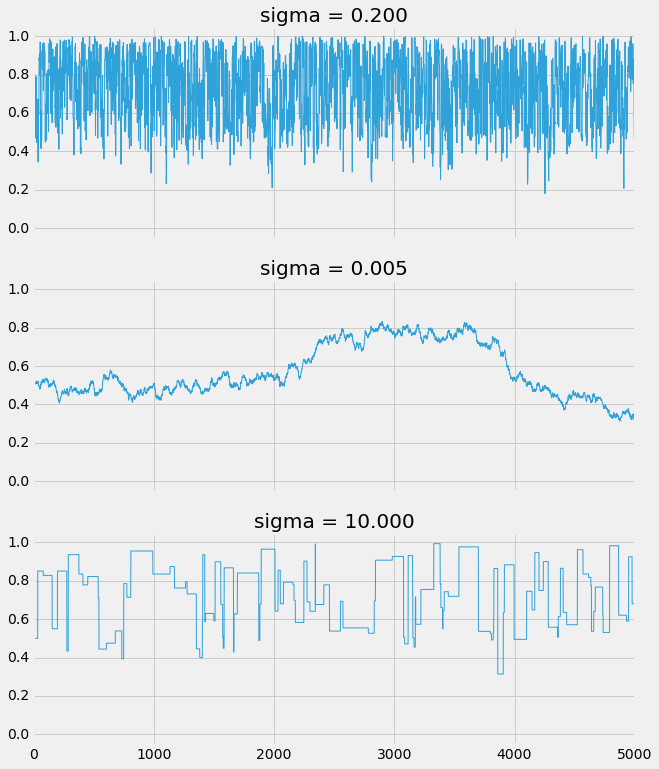

In [7]:
# plotting functions
mpl.rcParams['lines.linewidth'] = 1
f, ax = plt.subplots(3, sharex=True)
f.set_figheight(_plt_x)
f.set_figwidth(_plt_y)

sig = [0.2, 0.005, 10.]

for i, s in enumerate(sig):
    q = lambda x: s * np.random.randn() + x
    z = metropolis(N, z_0, p_tilde, q)
    idx = np.arange(z.shape[0])

    ax[i].plot(idx, z)
    ax[i].set_ylim([-0.05, 1.05])
    ax[i].set_title('sigma = %1.3f' % s)

plt.show()

# plotting functions
mpl.rcParams['lines.linewidth'] = 4


# Gibbs Sampling

Idea: if we can cheaply sample from conditional distributions, lets use that for the proposal distribution

Given $p(\mathbf{z}) = p(z_1, z_2, \dots, z_M)$

Generate a sample by sampling $z_i ~ p(z_i | \mathbf{z}_{\neg i})$

e.g. Given $p(z_1, z_2, z_3)$, we sample as follows:
$$
z_1^{(t+1)} \sim p(z_1 | z_2^{(t)}, z_3^{(t)})
$$

$$
z_2^{(t+1)} \sim p(z_2 | z_1^{(t+1)}, z_3^{(t)})
$$

$$
z_3^{(t+1)} \sim p(z_3 | z_2^{(t+1)}, z_3^{(t+1)})
$$


# Gibbs Sampling as a special case of Metropolis-Hastings

Let $q_k(\mathbf{z}^\star | \mathbf{z}) = p(z_k | \mathbf{z}_{\neg k})$ where we keep all $z_i,\, i\neq k$ unchanged.

Also, $p(\mathbf{z}) = p(z_k | \mathbf{z}_{\neg k})p(\mathbf{z}_{\neg k})$.

So,
$$
A(\mathbf{z}^\star | \mathbf{z}) = \frac{p(\mathbf{z}^\star)q_k(\mathbf{z} | \mathbf{z}^\star)}{p(\mathbf{z})q_k(\mathbf{z}^\star | \mathbf{z})} = \frac{p(z_k^\star | \mathbf{z}_{\neg k}^\star) p(\mathbf{z}^\star_{\neg k}) p(z_k | \mathbf{z}_{\neg k}^\star)}{p(z_k | \mathbf{z}_{\neg k}) p(\mathbf{z}_{\neg k}) p(z_k^\star | \mathbf{z}_{\neg k})} = 1
$$

i.e. The acceptance probability is just 1. for every sample.


# Gibbs use cases

Gibbs sampling is most useful when we can easily sample from the conditionals $p(z_k | \mathbf{z}_{\neg k})$. See the graphical models lectures from last year...

It is not always useful... e.g. sampling from correlated Gaussian, where we need $\mathcal{O}((L/l)^2)$ Gibbs steps to obtain an independent sample:

![](Gibbs.jpg)



# Simple Ising Model example

To illustrate let's perform Gibbs sampling on a simple *Ising* model. 

$$
\mathbb{P}(X^{i, j} = x^{i, j} \text{ for all } (i, j)) = \frac{1}{Z} \exp\left(\frac{1}{T}\sum_{(i, j) \sim (k,l)} x^{i, j}x^{k, l}\right)
$$

In [8]:
def neighbours(i, j, L):
    return [(i + x, j + y) for x, y in (-1, 0), (1, 0), (0, -1), (0, 1) if (0 <= i + x < L) and (0 <= j + y < L)]

def potential(i, j, X, T=1):
    L, _ = X.shape
    p = 0
    for _i, _j in neighbours(i, j, L):
        p += X[_i, _j]
    n = np.exp(T * p)
    return n / (n + np.exp(-T * p))

N = 50000 # number of samples
L = 100 # edge length of the image
x = np.random.binomial(1, 0.5, L*L).reshape((L, L)) * 2 - 1
X = np.repeat(x.reshape(1, L, L), N, axis=0)
T = 1.
for i in range(1, N):
    X[i, :, :] = x
    # we just choose a random pixel to perturb
    _i = np.random.randint(L)
    _j = np.random.randint(L)
    p = potential(_i, _j, X[i, :, :], T)
    val = np.random.binomial(1, p) * 2 - 1
    X[i, _i, _j] = val
    x = X[i, :, :]


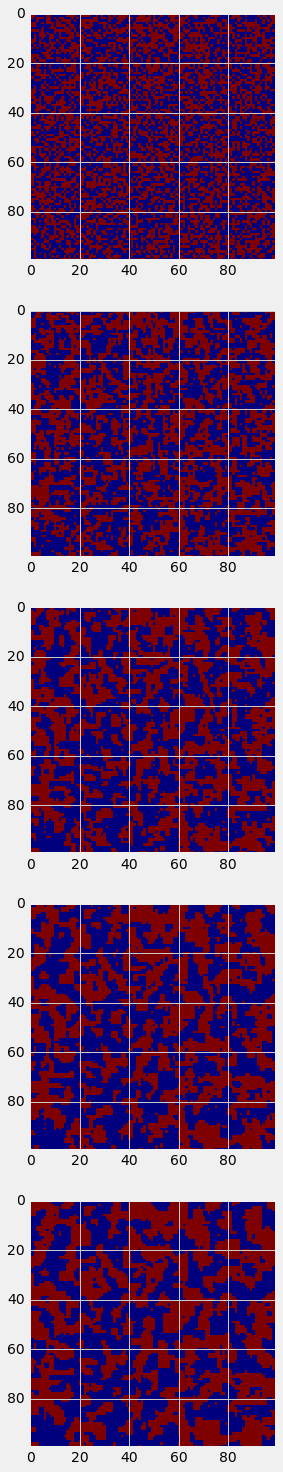

In [9]:
f, ax = plt.subplots(5)
f.set_figheight(_plt_x*2)
f.set_figwidth(_plt_y*2)

for i in range(5):
    ax[i].imshow(X[i*10000, :, :], interpolation='nearest')

# Slice Sampling

![](Slice1.jpg)
## Algorithm

For a given value $z^{(t)}$, choose $u$ uniformly in the region $0 \leq u \leq \tilde{p}(z^{(t)})$

Sample $z^{(t+1)}$ uniformly from the ‘slice’ defined by $u$ (shown by the solid horizontal lines). 

Because it is typically infeasible to sample directly from a slice, a new sample of z is drawn from a region $z_{\min} \leq z \leq z_{\max}$, which contains the previous value $z^{(t)}$. (see plot below)


![](slice2.jpg)

#### Why it works
Slice sampling is a **auxiliary** variable method where we augment $\mathbf{z}$ with and additional variable $u$  and then draw samples from their joint space $p(\mathbf{z}, u)$.
$$
p(\mathbf{z}, u) = \begin{cases}
1/{Z_p}&\text{ if } 0 \leq u \leq \tilde{p}(z)\\
0 & \text{otherwise}
\end{cases}
$$

where $Z_p = \int \tilde{p}(z) \text{ d}z$.

Given this definition of the joint distribution, we can get the marginal over $z$ by integrating out $u$.

$$
\int \tilde{p}(z, u) \text{ d}u = \int_{0}^{\tilde{p}(z)} \frac{1}{Z_p} = \frac{\tilde{p}(z)}{Z_p} = p(z)
$$

So we can sample from $p(z)$ by sampling from $p(z, u)$ and then ignoring the $u$ values.

# Summary

* We want to be able to compute $E[f(\cdot)] = \int  f(\mathbf{z}) p(\mathbf{z})\text{ d}\mathbf{z}\approx \frac{1}{N}\sum_{i=1}^N f(\mathbf{z}_i)$
* Rejection sampling and importance sampling are effective in low dimensions
* MCMC allows us to 

In [ ]:
# Code to generate the normal distribution plot shown in section 3
sig_p = 1.
p = normal_pdf(0., sig_p)
sig_q = 1.2
q = normal_pdf(0., sig_q)
k = sig_q / sig_p
x = np.arange(-4., 4., 0.01)

plt.figure(figsize=(_plt_x,_plt_y))
plt.plot(x, p(x), label='p(x)')
plt.plot(x, k*q(x), label='q(x)')
plt.ylim(-0.01, 0.45)
plt.legend()
plt.savefig('normaldist.jpg')